# Analyse von Audio Dateien zur Erkennung des Geschlechts
## 1. Einlesen einer csv Datei
Die Datei enthält alle zuvor extrahierten Audio Features und das Ziellabel Geschlecht.

In [1]:
!pip install boto3
!conda install dask -y
!pip install fsspec
#!pip install pandas==0.22 # für macOS
#!pip install s3fs # wenn S3 Bucket verwendet wird
!pip install sklearn
!pip install keras
!pip install tensorflow

typing-extensions 3.7.4.1 has requirement typing>=3.7.4; python_version < "3.5", but you'll have typing 3.6.4 which is incompatible.
You are using pip version 10.0.1, however version 20.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/amazonei_mxnet_p27

  added / updated specs: 
    - dask


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    dask-1.2.2                 |             py_0          11 KB

The following packages will be UPDATED:

    bokeh:       0.12.16-py27_0 --> 1.4.0-py27_0 
    dask:        0.17.5-py27_0  --> 1.2.2-py_0   
    dask-core:   0.17.5-py27

In [3]:
import os
import boto3
import pandas as pd
import sys
from io import StringIO
import dask.dataframe as dd
import numpy as np

## für Zugriff auf S3 gespeicherte Version
#bucket_name = 'analyseprojectaudio'
#object_key = 'multipart_files/FeaturesExtracted.csv'
#s3 = boto3.client('s3')
#df = pd.read_csv ('s3://' + bucket_name+'/'+object_key, delimiter =';')

# lokaler CSV-Import
# df = pd.read_csv ('/home/sebastian/Schreibtisch/BDC/features_extracted/FeaturesExtracted.csv', delimiter =';')
df = pd.read_csv ('/home/ec2-user/SageMaker/voice_gender_age/AgeWithGenderDetection')

In [8]:
# Ausgabe current working directory
import os
os.getcwd()

'/home/ec2-user/SageMaker/voice_gender_age/AgeWithGenderDetection'

Für die weitere Verarbeitung werden alle Spaltennamen in eine Liste übernommen. Es werden nur die Spaltennamen der Audio Features beibehalten

In [5]:
list_cn = df.columns.values
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn

array(['zcr', 'energy', 'energy_entropy', 'spectral_centroid',
       'spectral_spread', 'spectral_entropy', 'spectral_flux',
       'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4',
       'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
       'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7',
       'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'chroma_std'], dtype=object)

In der folgenden Schleife wird der DataFrame bearbeitet:
Es werden als String erkannte character ([]) entfernt.
Anschließend werden alle String - Werte eines Elements in ein NumPy Array gewandelt und in eine Liste zwischengespeichert.
Die Liste wird zurück in das Element das DataFrame geschrieben und der Median gebildet.
Dies ist notwendig um das richtige Format zur Eingabe in das Neuronale Netz zu erhalten.

In [6]:
nrows = len(df)

for i in range (0,nrows):
    for j in list_cn:
        list_c = df[j].iloc[i]
        list_c = list_c.replace('[','')
        list_c = list_c.replace(']','')
        list1 = np.fromstring (list_c, sep=' ',dtype=float)
        df[j].iat[i] = list1
        df[j].iat[i] = df[j].iloc[i].mean()
    if (i % 10000 == 0):
        print ("Reihe "+ str(i) + " fertig")
print ("Konvertierung abgeschlossen.")

Reihe 0 fertig
Reihe 10000 fertig
Reihe 20000 fertig
Reihe 30000 fertig
Reihe 40000 fertig
Reihe 50000 fertig
Konvertierung abgeschlossen.


Anschließend werden die nicht benötigten Spalten aus dem DataFrame entfernt

In [7]:
df.head()

Unnamed: 0  index                          path        age  gender  \
0           0      0  common_voice_de_17325303.mp3      teens  female   
1           1      1  common_voice_de_18201555.mp3   thirties  female   
2           2      2  common_voice_de_17340778.mp3  seventies  female   
3           3      3  common_voice_de_17340779.mp3  seventies  female   
4           4      4  common_voice_de_18001112.mp3   thirties  female   

                      file_wave        zcr     energy energy_entropy  \
0  common_voice_de_17325303.wav  0.0642394  0.0135318        3.02116   
1  common_voice_de_18201555.wav  0.0267417  0.0130014        2.77044   
2  common_voice_de_17340778.wav   0.105491  0.0121004        3.03186   
3  common_voice_de_17340779.wav  0.0785068  0.0224792        3.00399   
4  common_voice_de_18001112.wav  0.0639123  0.0228039        2.93814   

  spectral_centroid  ...    chroma_4    chroma_5    chroma_6   chroma_7  \
0           0.16407  ...  0.00934431  0.00991758  0.00562172  0.0287514   
1          0.132734  ...  0.00155354  0.00371185  0.00130747   0.189198   
2          0.152934  ...  0.00936951   0.0113756   0.0128234  0.0129994   
3          0.135851  ...  0.00868118   0.0148549   0.0350073  0.0311008   
4          0.125391  ...   0.0180194   0.0127522  0.00865218  0.0297006   

     chroma_8    chroma_9  chroma_10   chroma_11    chroma_12 chroma_std  
0    0.002562  0.00438808   0.011294   0.0194284   0.00393223  0.0291324  
1  0.00100479  0.00284188  0.0180358   0.0157503  0.000653381  0.0577428  
2  0.00375398   0.0122628  0.0134202  0.00987359   0.00372229  0.0145285  
3  0.00233811   0.0120349  0.0214039    0.023406   0.00720268  0.0240949  
4  0.00205647  0.00680324  0.0193026    0.032946   0.00766575  0.0291375  

[5 rows x 40 columns]

# Shuffeln!

In [8]:
df2 = df.sample(frac=1)
df2.head()

Unnamed: 0  index                          path       age  gender  \
649           649    649  common_voice_de_17753254.mp3  twenties  female   
51404       51404  51404  common_voice_de_17479402.mp3   fifties    male   
46699       46699  46699  common_voice_de_18619350.mp3  thirties    male   
20247       20247  20247  common_voice_de_18352722.mp3  fourties  female   
1809         1809   1809  common_voice_de_18213764.mp3  twenties  female   

                          file_wave        zcr      energy energy_entropy  \
649    common_voice_de_17753254.wav  0.0490945   0.0173147        2.94277   
51404  common_voice_de_17479402.wav  0.0632879   0.0286906        2.98249   
46699  common_voice_de_18619350.wav  0.0431645   0.0203229        2.96907   
20247  common_voice_de_18352722.wav  0.0563983   0.0106395        2.87296   
1809   common_voice_de_18213764.wav   0.102153  0.00740932        2.84275   

      spectral_centroid  ...    chroma_4    chroma_5    chroma_6   chroma_7  \
649             0.10628  ...   0.0183415   0.0136261  0.00933419  0.0130843   
51404          0.137093  ...  0.00372335   0.0294908  0.00277453  0.0969339   
46699          0.103146  ...   0.0175145   0.0399932  0.00647084  0.0496926   
20247          0.111948  ...  0.00976796   0.0122547  0.00967626  0.0293312   
1809           0.168515  ...   0.0258992  0.00960618   0.0077839  0.0286604   

          chroma_8    chroma_9   chroma_10   chroma_11   chroma_12 chroma_std  
649     0.00343776  0.00606403  0.00787535   0.0109264   0.0096343  0.0218047  
51404  0.000622527  0.00735068   0.0244224   0.0133793  0.00233316  0.0382166  
46699  0.000702465  0.00377809   0.0224511   0.0201751  0.00656356  0.0337198  
20247   0.00237465  0.00367792   0.0102666   0.0360087  0.00732901   0.025971  
1809    0.00536713   0.0116097  0.00765462  0.00881597  0.00323486  0.0227307  

[5 rows x 40 columns]

In [11]:
#!Änderung: weder gender noch age entfernen
df_gesamt = df2.copy()
del df_gesamt['Unnamed: 0']
del df_gesamt['index']
del df_gesamt['path']
#del df_gesamt['gender']
del df_gesamt['file_wave']

In [12]:
df_gesamt.head()

age  gender        zcr      energy energy_entropy  \
649    twenties  female  0.0490945   0.0173147        2.94277   
51404   fifties    male  0.0632879   0.0286906        2.98249   
46699  thirties    male  0.0431645   0.0203229        2.96907   
20247  fourties  female  0.0563983   0.0106395        2.87296   
1809   twenties  female   0.102153  0.00740932        2.84275   

      spectral_centroid spectral_spread spectral_entropy spectral_flux  \
649             0.10628        0.155355          0.32105    0.00815487   
51404          0.137093        0.163625          0.40139     0.0100012   
46699          0.103146         0.15284         0.258492    0.00721514   
20247          0.111948        0.152311         0.409442     0.0065248   
1809           0.168515         0.16374         0.739221    0.00575333   

      spectral_rolloff  ...    chroma_4    chroma_5    chroma_6   chroma_7  \
649          0.0658642  ...   0.0183415   0.0136261  0.00933419  0.0130843   
51404        0.0867098  ...  0.00372335   0.0294908  0.00277453  0.0969339   
46699         0.057195  ...   0.0175145   0.0399932  0.00647084  0.0496926   
20247        0.0780836  ...  0.00976796   0.0122547  0.00967626  0.0293312   
1809          0.138729  ...   0.0258992  0.00960618   0.0077839  0.0286604   

          chroma_8    chroma_9   chroma_10   chroma_11   chroma_12 chroma_std  
649     0.00343776  0.00606403  0.00787535   0.0109264   0.0096343  0.0218047  
51404  0.000622527  0.00735068   0.0244224   0.0133793  0.00233316  0.0382166  
46699  0.000702465  0.00377809   0.0224511   0.0201751  0.00656356  0.0337198  
20247   0.00237465  0.00367792   0.0102666   0.0360087  0.00732901   0.025971  
1809    0.00536713   0.0116097  0.00765462  0.00881597  0.00323486  0.0227307  

[5 rows x 36 columns]

In [13]:
#Anderung: age statt gender entfernen
df_data_x = df_gesamt
del df_gesamt['age']
df_data_x.head()

gender        zcr      energy energy_entropy spectral_centroid  \
649    female  0.0490945   0.0173147        2.94277           0.10628   
51404    male  0.0632879   0.0286906        2.98249          0.137093   
46699    male  0.0431645   0.0203229        2.96907          0.103146   
20247  female  0.0563983   0.0106395        2.87296          0.111948   
1809   female   0.102153  0.00740932        2.84275          0.168515   

      spectral_spread spectral_entropy spectral_flux spectral_rolloff  \
649          0.155355          0.32105    0.00815487        0.0658642   
51404        0.163625          0.40139     0.0100012        0.0867098   
46699         0.15284         0.258492    0.00721514         0.057195   
20247        0.152311         0.409442     0.0065248        0.0780836   
1809          0.16374         0.739221    0.00575333         0.138729   

        mfcc_1  ...    chroma_4    chroma_5    chroma_6   chroma_7  \
649   -30.2627  ...   0.0183415   0.0136261  0.00933419  0.0130843   
51404 -28.9224  ...  0.00372335   0.0294908  0.00277453  0.0969339   
46699 -28.6662  ...   0.0175145   0.0399932  0.00647084  0.0496926   
20247 -30.0491  ...  0.00976796   0.0122547  0.00967626  0.0293312   
1809  -31.5045  ...   0.0258992  0.00960618   0.0077839  0.0286604   

          chroma_8    chroma_9   chroma_10   chroma_11   chroma_12 chroma_std  
649     0.00343776  0.00606403  0.00787535   0.0109264   0.0096343  0.0218047  
51404  0.000622527  0.00735068   0.0244224   0.0133793  0.00233316  0.0382166  
46699  0.000702465  0.00377809   0.0224511   0.0201751  0.00656356  0.0337198  
20247   0.00237465  0.00367792   0.0102666   0.0360087  0.00732901   0.025971  
1809    0.00536713   0.0116097  0.00765462  0.00881597  0.00323486  0.0227307  

[5 rows x 35 columns]

Die Zielvariable (Gender) wird in eine eigene Liste (?) geschrieben. Da das neuronale Netz nur mit Integer bzw. Float als Zieldatentyp arbeiten kann, wir mit Hilfe der Methode LabelEncoder das Geschlacht als 0 und 1 kodiert:

In [14]:
#!Änderung: Name des dfs statt df_gender_y in age
# Erstellen eines df mit Zielvariable gender
df_age_y = df2.age.copy()
df_age_y.head(30)

649      twenties
51404     fifties
46699    thirties
20247    fourties
1809     twenties
48775    thirties
26826    fourties
32491    twenties
47337    thirties
44142    twenties
37351     sixties
39454    fourties
9204     thirties
10678    twenties
47633     fifties
30283    thirties
33607    twenties
53830    fourties
1779     twenties
24261    fourties
24319    fourties
10356    twenties
6680     twenties
45492    twenties
28508    twenties
29522    twenties
11639     fifties
3060     thirties
51463    thirties
19751    fourties
Name: age, dtype: object

In [15]:
#!Änderung: Name des dfs statt df_gender_y in age
from sklearn.preprocessing import LabelEncoder
# integer encode
label_encoder = LabelEncoder()
df_age_y = label_encoder.fit_transform(df_age_y)
print(df_age_y[56420])

6


In [24]:
print(df_age_y)

[6 0 5 ... 1 0 5]


In [35]:
#Anderung: age statt gender entfernen
#df_data_gender = df_gesamt
#del df_gesamt['age']
#df_data_gender.head()

gender        zcr     energy energy_entropy spectral_centroid  \
0  female  0.0642394  0.0135318        3.02116           0.16407   
1  female  0.0267417  0.0130014        2.77044          0.132734   
2  female   0.105491  0.0121004        3.03186          0.152934   
3  female  0.0785068  0.0224792        3.00399          0.135851   
4  female  0.0639123  0.0228039        2.93814          0.125391   

  spectral_spread spectral_entropy spectral_flux spectral_rolloff   mfcc_1  \
0        0.186696         0.678548    0.00499231         0.125793 -30.0566   
1        0.187806         0.178288     0.0230201        0.0299194 -33.0532   
2        0.138649         0.865054    0.00480058         0.159097 -29.2131   
3        0.159692         0.598381    0.00728212         0.123521 -27.8696   
4         0.15982         0.415072     0.0129393        0.0916925 -27.9538   

   ...    chroma_4    chroma_5    chroma_6   chroma_7    chroma_8    chroma_9  \
0  ...  0.00934431  0.00991758  0.00562172  0.0287514    0.002562  0.00438808   
1  ...  0.00155354  0.00371185  0.00130747   0.189198  0.00100479  0.00284188   
2  ...  0.00936951   0.0113756   0.0128234  0.0129994  0.00375398   0.0122628   
3  ...  0.00868118   0.0148549   0.0350073  0.0311008  0.00233811   0.0120349   
4  ...   0.0180194   0.0127522  0.00865218  0.0297006  0.00205647  0.00680324   

   chroma_10   chroma_11    chroma_12 chroma_std  
0   0.011294   0.0194284   0.00393223  0.0291324  
1  0.0180358   0.0157503  0.000653381  0.0577428  
2  0.0134202  0.00987359   0.00372229  0.0145285  
3  0.0214039    0.023406   0.00720268  0.0240949  
4  0.0193026    0.032946   0.00766575  0.0291375  

[5 rows x 35 columns]

In [54]:
#df_data_gender2 = df_data_gender['gender']
#df_data_gender2.tail(30)

56416    male
56417    male
56418    male
56419    male
56420    male
56421    male
56422    male
56423    male
56424    male
56425    male
56426    male
56427    male
56428    male
56429    male
56430    male
56431    male
56432    male
56433    male
56434    male
56435    male
56436    male
56437    male
56438    male
56439    male
56440    male
56441    male
56442    male
56443    male
56444    male
56445    male
Name: gender, dtype: object

In [38]:
##!Änderung: Name des dfs statt df_gender_y in age
#from sklearn.preprocessing import LabelEncoder
# integer encode
#label_encoder = LabelEncoder()
#df_data_gender2 = label_encoder.fit_transform(df_data_gender2)
#print(df_data_gender2[56420])

1


In [16]:
#df_gesamt.head()

gender        zcr      energy energy_entropy spectral_centroid  \
649    female  0.0490945   0.0173147        2.94277           0.10628   
51404    male  0.0632879   0.0286906        2.98249          0.137093   
46699    male  0.0431645   0.0203229        2.96907          0.103146   
20247  female  0.0563983   0.0106395        2.87296          0.111948   
1809   female   0.102153  0.00740932        2.84275          0.168515   

      spectral_spread spectral_entropy spectral_flux spectral_rolloff  \
649          0.155355          0.32105    0.00815487        0.0658642   
51404        0.163625          0.40139     0.0100012        0.0867098   
46699         0.15284         0.258492    0.00721514         0.057195   
20247        0.152311         0.409442     0.0065248        0.0780836   
1809          0.16374         0.739221    0.00575333         0.138729   

        mfcc_1  ...    chroma_4    chroma_5    chroma_6   chroma_7  \
649   -30.2627  ...   0.0183415   0.0136261  0.00933419  0.0130843   
51404 -28.9224  ...  0.00372335   0.0294908  0.00277453  0.0969339   
46699 -28.6662  ...   0.0175145   0.0399932  0.00647084  0.0496926   
20247 -30.0491  ...  0.00976796   0.0122547  0.00967626  0.0293312   
1809  -31.5045  ...   0.0258992  0.00960618   0.0077839  0.0286604   

          chroma_8    chroma_9   chroma_10   chroma_11   chroma_12 chroma_std  
649     0.00343776  0.00606403  0.00787535   0.0109264   0.0096343  0.0218047  
51404  0.000622527  0.00735068   0.0244224   0.0133793  0.00233316  0.0382166  
46699  0.000702465  0.00377809   0.0224511   0.0201751  0.00656356  0.0337198  
20247   0.00237465  0.00367792   0.0102666   0.0360087  0.00732901   0.025971  
1809    0.00536713   0.0116097  0.00765462  0.00881597  0.00323486  0.0227307  

[5 rows x 35 columns]

In [17]:
import re

In [18]:
#df_gesamt = pd.concat([df_gesamt,df_data_gender2])
#df_gesamt.head()
df_gesamt['gender']= df_gesamt['gender'].apply(lambda x: ' '.join([re.sub('female','1', x)]))
df_gesamt.tail()

gender        zcr     energy energy_entropy spectral_centroid  \
14990      1  0.0888912  0.0262718        2.78702          0.163617   
5266       1  0.0976152    0.04666         3.0906           0.17572   
24760      1  0.0701991  0.0194969        2.88738          0.121176   
13412      1  0.0643787  0.0108015          2.749           0.11502   
38534   male  0.0471737  0.0212338        3.00172          0.120594   

      spectral_spread spectral_entropy spectral_flux spectral_rolloff  \
14990        0.191545         0.496621    0.00989072         0.130141   
5266         0.183177         0.672435    0.00538819         0.163566   
24760        0.142284          0.47121    0.00666382         0.109651   
13412        0.114395         0.607444     0.0169794        0.0886806   
38534         0.17148          0.27437    0.00864866        0.0619916   

        mfcc_1  ...    chroma_4    chroma_5    chroma_6   chroma_7  \
14990 -28.3704  ...   0.0264325   0.0183399   0.0077706  0.0239231   
5266  -26.4289  ...  0.00864134  0.00566849  0.00396928  0.0184743   
24760 -27.7272  ...   0.0119705   0.0125855   0.0120867  0.0206947   
13412 -35.4663  ...  0.00573133   0.0141316  0.00664988  0.0560726   
38534 -27.3222  ...   0.0130871   0.0230479    0.012298  0.0761614   

         chroma_8    chroma_9   chroma_10  chroma_11   chroma_12 chroma_std  
14990  0.00139146  0.00355892   0.0379548  0.0326146  0.00464658  0.0298176  
5266    0.0013166  0.00625747   0.0439688  0.0351625  0.00348038  0.0318672  
24760  0.00266974  0.00370537   0.0103243  0.0221938  0.00629482  0.0192825  
13412  0.00184379   0.0066867  0.00917559  0.0138296  0.00679265  0.0225649  
38534  0.00513288  0.00761446    0.013922  0.0319691  0.00500205  0.0317294  

[5 rows x 35 columns]

In [19]:
#df_gesamt = pd.concat([df_gesamt,df_data_gender2])
#df_gesamt.head()
df_gesamt['gender']= df_gesamt['gender'].apply(lambda x: ' '.join([re.sub('male','0', x)]))
df_gesamt.tail()

gender        zcr     energy energy_entropy spectral_centroid  \
14990      1  0.0888912  0.0262718        2.78702          0.163617   
5266       1  0.0976152    0.04666         3.0906           0.17572   
24760      1  0.0701991  0.0194969        2.88738          0.121176   
13412      1  0.0643787  0.0108015          2.749           0.11502   
38534      0  0.0471737  0.0212338        3.00172          0.120594   

      spectral_spread spectral_entropy spectral_flux spectral_rolloff  \
14990        0.191545         0.496621    0.00989072         0.130141   
5266         0.183177         0.672435    0.00538819         0.163566   
24760        0.142284          0.47121    0.00666382         0.109651   
13412        0.114395         0.607444     0.0169794        0.0886806   
38534         0.17148          0.27437    0.00864866        0.0619916   

        mfcc_1  ...    chroma_4    chroma_5    chroma_6   chroma_7  \
14990 -28.3704  ...   0.0264325   0.0183399   0.0077706  0.0239231   
5266  -26.4289  ...  0.00864134  0.00566849  0.00396928  0.0184743   
24760 -27.7272  ...   0.0119705   0.0125855   0.0120867  0.0206947   
13412 -35.4663  ...  0.00573133   0.0141316  0.00664988  0.0560726   
38534 -27.3222  ...   0.0130871   0.0230479    0.012298  0.0761614   

         chroma_8    chroma_9   chroma_10  chroma_11   chroma_12 chroma_std  
14990  0.00139146  0.00355892   0.0379548  0.0326146  0.00464658  0.0298176  
5266    0.0013166  0.00625747   0.0439688  0.0351625  0.00348038  0.0318672  
24760  0.00266974  0.00370537   0.0103243  0.0221938  0.00629482  0.0192825  
13412  0.00184379   0.0066867  0.00917559  0.0138296  0.00679265  0.0225649  
38534  0.00513288  0.00761446    0.013922  0.0319691  0.00500205  0.0317294  

[5 rows x 35 columns]

In [12]:
#die loss funktion categorical_crossentropy erwartet als eingabe ein Array, keine int werte, deshalb wurde die Zielvariable umgeformt
#from keras.utils import to_categorical
#df_age_y2 = to_categorical(df_age_y)

Using TensorFlow backend.


In [13]:
#print(df_age_y2[0])

[0. 0. 0. 0. 1. 0. 0.]


Für das neuronale Netz verwenden wir Keras.
Folgende Funktionen werden aus Keras verwendet:
- Sequential
- Dense
- Activation

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


Im folgenden Schritt wird das neuronale Netz konfiguriert:
Genaue Beschreibung, mit welchen Konfiguration welches Ergebnis erreicht wurde

In [21]:
# model konfigurieren
# softmax, sigmoid
#model.add (Dense (30, input_dim = 34, activation = 'relu'))
#model.add (Dense (10, activation = 'relu'))
#60%val_acc bei 2hidden mit 100 Knoten jeweils mit relu / dense last Dense =7/actication softmax / loss = 'categorical_crossentropy', optimizer = 'adam'
#mit den einstellungen schafft man 63,66%

model = Sequential()
#hier muss beim Versuch mit Gender als Trainingsmerkmal eine 35 statt eine 34 stehen!
model.add (Dense (35, input_dim = 35, activation = 'relu'))
model.add (Dense (100, activation = 'relu'))
model.add (Dense (100, activation = 'relu'))
#model.add (Dense (100, activation = 'relu'))
model.add (Dense (7, activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 35)                1260      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               3600      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 707       
Total params: 15,667
Trainable params: 15,667
Non-trainable params: 0
_________________________________________________________________


Im nächsten Schritt wird das Modell kompiliert.
Als Loss Funktion wird die Methode "Mean Squared Error" genutzt. "Adam" wird als Optimierungsfunktion genutzt.

In [22]:
model.compile (loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['sparse_categorical_crossentropy','acc'])

Dann wird das Modell trainiert. Die Validierung erfolgt direkt mit dem Training mit 33% der Gesamt-Daten

In [25]:
import time

# Startzeit
t = time.localtime()
current_time = time.strftime("%d.%m.%Y %H:%M:%S", t)
print(current_time, ' Training gestartet ...')

# Model trainieren
history = model.fit (df_gesamt, df_age_y, epochs = 100, validation_split = 0.3, batch_size = 10)

# Endzeit
t2 = time.localtime()
current_time2 = time.strftime("%d.%m.%Y %H:%M:%S", t2)
print(current_time2, ' Training beendet ...')

18.05.2020 08:57:23  Training gestartet ...
Train on 39512 samples, validate on 16934 samples
Epoch 1/100
39512/39512 [==============================] - 8s 193us/step - loss: 1.3270 - sparse_categorical_crossentropy: 1.3270 - acc: 0.4562 - val_loss: 1.1986 - val_sparse_categorical_crossentropy: 1.1986 - val_acc: 0.5063
Epoch 2/100
39512/39512 [==============================] - 7s 188us/step - loss: 1.1709 - sparse_categorical_crossentropy: 1.1709 - acc: 0.5211 - val_loss: 1.0771 - val_sparse_categorical_crossentropy: 1.0771 - val_acc: 0.5707
Epoch 3/100
39512/39512 [==============================] - 7s 189us/step - loss: 1.0445 - sparse_categorical_crossentropy: 1.0445 - acc: 0.5959 - val_loss: 1.0094 - val_sparse_categorical_crossentropy: 1.0094 - val_acc: 0.6152
Epoch 4/100
39512/39512 [==============================] - 7s 177us/step - loss: 0.9750 - sparse_categorical_crossentropy: 0.9750 - acc: 0.6241 - val_loss: 0.9180 - val_sparse_categorical_crossentropy: 0.9180 - val_acc: 0.651

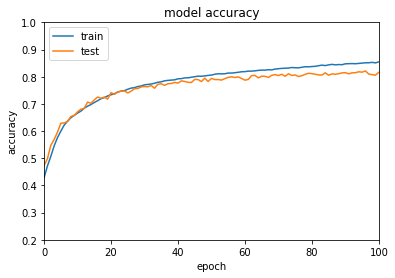

In [45]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.axis([0, 100, 0.2, 1])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#print(history.history.keys())

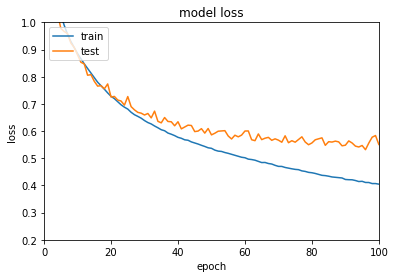

In [46]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.axis([0, 100, 0.2, 1])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Optimales Modell finden mittels CV¶

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
#Optimierungsfunktion für Modell
def c_modelOpti(optimizer, activation):
    model = Sequential()
    model.add(Dense(35, input_dim = 35, activation = activation))
    model.add (Dense (100, activation = activation))
    model.add (Dense (100, activation = activation))
    model.add (Dense (7, activation = 'softmax'))
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["sparse_categorical_crossentropy","acc"])
    return model

In [31]:
model.compile (loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['categorical_crossentropy','acc'])

In [32]:
from keras.wrappers.scikit_learn import KerasClassifier

In [33]:
model = KerasClassifier(build_fn=c_modelOpti)

epoches = [50, 100, 150]
optimizers = ['Adam', 'Adamax', 'SGD', 'RMSprop', 'Adadelta']
activations = ['softmax', 'relu', 'elu', 'selu', 'linear']

parameters = {'epochs': epoches, 'optimizer': optimizers, 'activation': activations}

clf = GridSearchCV(model, parameters)

# Startzeit
t = time.localtime()
current_time = time.strftime("%d.%m.%Y %H:%M:%S", t)
print(current_time, ' Training gestartet ...\n')

# Modell trainieren
clf.fit(df_gesamt, df_age_y, validation_split = 0.3)

# Endzeit
t2 = time.localtime()
current_time2 = time.strftime("%d.%m.%Y %H:%M:%S", t2)
print(' ')
print(current_time2, 'Training beendet ...')

18.05.2020 09:13:34  Training gestartet ...



/home/sebastian/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Train on 26341 samples, validate on 11289 samples
Epoch 1/50
26341/26341 [==============================] - 2s 86us/step - loss: 1.6681 - sparse_categorical_crossentropy: 1.6681 - acc: 0.3306 - val_loss: 1.5528 - val_sparse_categorical_crossentropy: 1.5528 - val_acc: 0.3305
Epoch 2/50
26341/26341 [==============================] - 2s 80us/step - loss: 1.5457 - sparse_categorical_crossentropy: 1.5457 - acc: 0.3332 - val_loss: 1.5282 - val_sparse_categorical_crossentropy: 1.5282 - val_acc: 0.3305
Epoch 3/50
26341/26341 [==============================] - 2s 80us/step - loss: 1.5343 - sparse_categorical_crossentropy: 1.5343 - acc: 0.3332 - val_loss: 1.5229 - val_sparse_categorical_crossentropy: 1.5229 - val_acc: 0.3305
Epoch 4/50
26341/26341 [==============================] - 2s 81us/step - loss: 1.5317 - sparse_categorical_crossentropy: 1.5317 - acc: 0.3332 - val_loss: 1.5221 - val_sparse_categorical_crossentropy: 1.5221 - val_acc: 0.3305
Epoch 5/50
26341/26341 [==========================

Optimales Modell finden!
Im folgenden Schritt wird das neuronale Netz konfiguriert: Genaue Beschreibung, mit welchen Konfiguration welches Ergebnis erreicht wurde

In [35]:
# Parameter ausgeben
print(clf.best_score_, clf.best_params_)
means = clf.cv_results_['mean_test_score']
parameters = clf.cv_results_['params']

for mean, parameter in zip(means, parameters):
    print(mean, parameter)

0.802483796569672 {'activation': 'elu', 'epochs': 150, 'optimizer': 'Adamax'}
0.4946497558023676 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adam'}
0.49130141865223814 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adamax'}
0.3321758838051609 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'SGD'}
0.39294192141454354 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'RMSprop'}
0.3321758838051609 {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adadelta'}
0.4769159840121646 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adam'}
0.5176806118730929 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adamax'}
0.3321758838051609 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'SGD'}
0.4427948895991915 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'RMSprop'}
0.3321758838051609 {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adadelta'}
0.6034971399350418 {'activation': 'softmax', 'epochs': 150, 'optimizer': 'Adam'}
0.549658088084213 

In [36]:
means = clf.cv_results_['split1_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

0.501 (+/-0.011) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adam'}
0.490 (+/-0.014) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adamax'}
0.332 (+/-0.001) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'SGD'}
0.332 (+/-0.172) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'RMSprop'}
0.332 (+/-0.001) for {'activation': 'softmax', 'epochs': 50, 'optimizer': 'Adadelta'}
0.530 (+/-0.207) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adam'}
0.515 (+/-0.015) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adamax'}
0.332 (+/-0.001) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'SGD'}
0.522 (+/-0.162) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'RMSprop'}
0.332 (+/-0.001) for {'activation': 'softmax', 'epochs': 100, 'optimizer': 'Adadelta'}
0.602 (+/-0.008) for {'activation': 'softmax', 'epochs': 150, 'optimizer': 'Adam'}
0.550 (+/-0.018) for {'activation': 'softmax', 'epochs': 150, 'optimizer': '

# Optimale Parameter eintragen!

In [37]:
epochs_opti = 150
optimizer_opti = 'Adamax'
activation_opti = 'elu'

In [38]:
# bestes model konfigurieren
model = Sequential()
model.add(Dense (35, input_dim = 35, activation = activation_opti))
model.add (Dense (100, activation = activation_opti))
model.add (Dense (100, activation = activation_opti))
model.add (Dense (7, activation = 'softmax'))
model.summary()

Model: "sequential_228"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_909 (Dense)            (None, 35)                1260      
_________________________________________________________________
dense_910 (Dense)            (None, 100)               3600      
_________________________________________________________________
dense_911 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_912 (Dense)            (None, 7)                 707       
Total params: 15,667
Trainable params: 15,667
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Modell kompilieren
model.compile (loss = "sparse_categorical_crossentropy", optimizer = optimizer_opti, metrics = ["sparse_categorical_crossentropy","acc"])

In [40]:
import time

# Startzeit
t = time.localtime()
current_time = time.strftime("%d.%m.%Y %H:%M:%S", t)
print(current_time, ' Training gestartet ...\n')

# Model trainieren
history = model.fit (df_gesamt, df_age_y, epochs = epochs_opti, validation_split = 0.3)

# Endzeit
t2 = time.localtime()
current_time2 = time.strftime("%d.%m.%Y %H:%M:%S", t2)
print(' ')
print(current_time2, 'Training beendet ...')

19.05.2020 07:25:16  Training gestartet ...

Train on 39512 samples, validate on 16934 samples
Epoch 1/150
39512/39512 [==============================] - 3s 81us/step - loss: 1.3986 - sparse_categorical_crossentropy: 1.3986 - acc: 0.4281 - val_loss: 1.3155 - val_sparse_categorical_crossentropy: 1.3155 - val_acc: 0.4730
Epoch 2/150
39512/39512 [==============================] - 3s 75us/step - loss: 1.2762 - sparse_categorical_crossentropy: 1.2762 - acc: 0.4716 - val_loss: 1.2200 - val_sparse_categorical_crossentropy: 1.2200 - val_acc: 0.4982
Epoch 3/150
39512/39512 [==============================] - 3s 79us/step - loss: 1.1946 - sparse_categorical_crossentropy: 1.1946 - acc: 0.5065 - val_loss: 1.1386 - val_sparse_categorical_crossentropy: 1.1386 - val_acc: 0.5471
Epoch 4/150
39512/39512 [==============================] - 3s 73us/step - loss: 1.1297 - sparse_categorical_crossentropy: 1.1297 - acc: 0.5453 - val_loss: 1.0801 - val_sparse_categorical_crossentropy: 1.0801 - val_acc: 0.5686
E

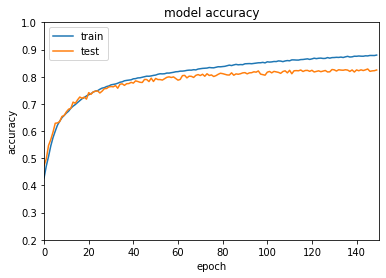

In [44]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.axis([0, 150, 0.2, 1])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

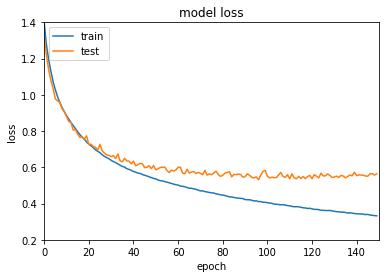

In [43]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.axis([0, 150, 0.2, 1.4])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Optimales Modell speichern

In [47]:
# Mit mode.to_json wird nur die Architektur gespeichert.
# Besser: model.save()
## model_json = model.to_json()
## file_name_json = "model.json"
## file_name_h5 = "model.h5"
## with open(file_name_json, "w") as json_file:
    ## json_file.write(model_json)
## serialize weights to HDF5
##model.save_weights(file_name_h5)


save_model = '/home/sebastian/Schreibtisch/BDC/Age_with_Gender_opti/model.h5'
model.save(save_model)
print("Saved model to disk")

Saved model to disk


# Testen des Modells mit ungelabelten Daten

Einlesen der Testdaten aus dem S3 Bucket

In [56]:
# von S3 lesen
#bucket_name = 'analyseprojectaudio'
#object_key = 'Test_Dateien/test_final_FeaturesExtracted.csv'
#s3 = boto3.client('s3')
#df_test = pd.read_csv ('s3://' + bucket_name+'/'+object_key, delimiter =';')

# von lokal lesen
df_test = pd.read_csv ('/home/sebastian/Schreibtisch/Gender_Age_Detection/test_final/test_final_FeaturesExtracted.csv', delimiter =';')

Die Input Datei für das Testen des Modells mit nicht gelabelten Daten wird analog zu den Test und Trainingsdatensätzen vorbereitet

In [57]:
list_cn = df_test.columns.values
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn = np.delete(list_cn,0)
list_cn

array(['zcr', 'energy', 'energy_entropy', 'spectral_centroid',
       'spectral_spread', 'spectral_entropy', 'spectral_flux',
       'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4',
       'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
       'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7',
       'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'chroma_std'], dtype=object)

In [58]:
nrows = len(df_test)

for i in range (0,nrows):
    for j in list_cn:
        list_c = df_test[j].iloc[i]
        list_c = list_c.replace('[','')
        list_c = list_c.replace(']','')
        list1 = np.fromstring (list_c, sep=' ',dtype=float)
        df_test[j].iat[i] = list1
        df_test[j].iat[i] = df_test[j].iloc[i].mean()
    if (i % 10000 == 0):
        print ("Reihe "+ str(i) + " fertig")
print ("Konvertierung abgeschlossen.")

Reihe 0 fertig
Konvertierung abgeschlossen.


In [59]:
df_test

Unnamed: 0  index           path       age  gender      file_wave  \
0           0      0  geilerTyp.mp3   fifties    male  geilerTyp.wav   
1           1      1       schr.mp3  fourties    male       schr.wav   
2           2      2        sk1.mp3  thirties    male        sk1.wav   
3           3      3        je1.mp3  thirties  female        je1.wav   
4           4      4        je2.mp3  thirties  female        je1.wav   
5           5      5         me.mp3  twenties  female         me.wav   
6           6      6         ke.mp3  twenties  female         ke.wav   

         zcr     energy energy_entropy spectral_centroid    ...      \
0  0.0435119   0.018574        3.01232          0.105139    ...       
1  0.0518132  0.0221208        2.93502          0.120971    ...       
2  0.0477583  0.0106856        2.93158          0.132843    ...       
3  0.0664128  0.0143529        2.90859          0.156188    ...       
4  0.0664128  0.0143529        2.90859          0.156188    ...       
5  0.0465894   0.017359        2.81086           0.10745    ...       
6  0.0245694  0.0119659        2.84867         0.0958715    ...       

     chroma_4   chroma_5    chroma_6   chroma_7     chroma_8    chroma_9  \
0  0.00782778  0.0158719  0.00797515  0.0751808   0.00166901  0.00864305   
1   0.0153491  0.0231022    0.014726  0.0267639   0.00210171    0.010222   
2   0.0119045  0.0322351  0.00820262  0.0504847    0.0053183  0.00800017   
3    0.010881  0.0139039   0.0106856  0.0644062  0.000928041  0.00568124   
4    0.010881  0.0139039   0.0106856  0.0644062  0.000928041  0.00568124   
5   0.0156644  0.0199885  0.00795671  0.0233293   0.00370495  0.00632902   
6   0.0314948   0.024657   0.0184142  0.0254578   0.00521319   0.0097329   

   chroma_10  chroma_11   chroma_12 chroma_std  
0  0.0120818  0.0374517  0.00636176  0.0302023  
1  0.0264008   0.019774  0.00701332  0.0269046  
2  0.0121582  0.0259356  0.00414674   0.031859  
3  0.0204463  0.0395585  0.00380728  0.0335224  
4  0.0204463  0.0395585  0.00380728  0.0335224  
5  0.0245737  0.0406926  0.00860004  0.0208492  
6  0.0172653  0.0264739  0.00517114  0.0315499  

[7 rows x 40 columns]

In [60]:
df_pred = df_test.copy()
del df_pred['Unnamed: 0']
del df_pred['index']
del df_pred['path']
del df_pred['age']
del df_pred['file_wave']
del df_pred['gender']

## Prediction der Testwerte
Die Ausgabe der Prediction gibt die vorhergesagte Klasse wieder (prediction_class)
0 = Male
1 = Female
Die Variable prediction_proba gibt die errechnete Wahrscheinlichkeit aus, dass es sich um die vorhergesagte Klasse handelt

In [61]:
for i in range (7):
    prediction = model.predict(df_pred.iloc[[i]])
    prediction_class = model.predict_classes(df_pred.iloc[[i]])
    prediction_proba = model.predict_proba(df_pred.iloc[[i]])
    print(prediction)
    print (prediction_class)
    #print (prediction_proba)
    print ("----------")

[[1.0270352]]
[[1]]
----------
[[0.94505775]]
[[1]]
----------
[[1.0122542]]
[[1]]
----------
[[0.12622088]]
[[0]]
----------
[[0.12622088]]
[[0]]
----------
[[0.99708176]]
[[1]]
----------
[[0.13873598]]
[[0]]
----------


/Users/sebastian/anaconda3/lib/python3.6/site-packages/keras/engine/sequential.py:248: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


# Der nachfolgende Code hilft bei der Überprüfung der Prediction

In [34]:
label_encoder = LabelEncoder()
df_test['gender_enc'] = label_encoder.fit_transform(df_test['gender'])
print(df_gender_y)

[0 0 0 ... 1 1 1]


In [35]:
df_test[['gender','gender_enc']]

gender  gender_enc
0    male           1
1    male           1
2    male           1
3  female           0
4  female           0
5  female           0
6  female           0